In [53]:
import torch 
from torch import nn
import numpy as np 
from tqdm import tqdm
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from torch.nn import functional as F

In [6]:
def learn_mapping(
    num_kv_pairs: int = 16, 
    d_model: int = 16, 
    pbar: bool = False, 
    num_epochs: int = 3_000,
    log_interval: int = 200,
    criterion: str = "mse"
):
    keys = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False))
    values = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False))
    embeddings = nn.Embedding(num_kv_pairs, d_model)

    class Layer(nn.Module):
        def __init__(
            self, 
            d_model: int = 16,
        ):
            super().__init__()

            self.layer1 = nn.Linear(d_model, d_model, bias=True)
            self.layer2 = nn.Linear(d_model, d_model, bias=True)
        
        def forward(self, x):
            x = torch.relu(self.layer1(x))
            y = self.layer2(x)
            return y 

    layer = Layer(d_model=d_model)

    layer.to(device='cuda')
    embeddings.to(device='cuda')
    keys = keys.to(device='cuda')
    values = values.to(device='cuda')

    # Define a loss function and an optimizer
    criterion = {
        "mse": lambda output, values: nn.MSELoss()(output, embeddings(values)), 
        "nll": lambda output, values: nn.CrossEntropyLoss()(output @ embeddings.weight.T, values)
    }[criterion]
    optimizer = torch.optim.SGD(layer.parameters(), lr=1)

    # Training loop
    metrics = []
    for epoch in tqdm(range(num_epochs), disable=not pbar):  # 500 epochs
        optimizer.zero_grad()   # zero the gradient buffers
        output = layer(embeddings(keys))    # Forward pass
        loss = criterion(output, values)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Does the update

        if (epoch + 1) % log_interval == 0:
            metrics.append({
                'epoch': epoch,
                'loss': loss.item(),
            })
    return metrics[-1], metrics

In [8]:
metrics, _ = learn_mapping(
    num_kv_pairs=16, 
    d_model=128, 
    num_epochs=1000,
    log_interval=100, 
    criterion="nll"

)
metrics

{'epoch': 999, 'loss': nan}

In [58]:
class Model(nn.Module):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        freeze_embeddings: bool = True,
        activation: callable = torch.relu
    ):
        super().__init__()
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model * 2, bias=True)
        self.layer2 = nn.Linear(d_model * 2, d_model, bias=True)
        self.activation = activation

    def forward(self, x):
        raise NotImplementedError

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        raise NotImplementedError

    def metrics(self, output: torch.Tensor, y:torch.Tensor): 
        return {}
    
def fit_model(
    num_kv_pairs: int = 16, 
    d_model: int = 16, 
    pbar: bool = False, 
    num_epochs: int = 3_000,
    log_interval: int = 200,
    device: int = 0, 
    model_cls: type = Model,
    **kwargs
):
    keys = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False)).to(device)
    values = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False)).to(device)

    model = model_cls(num_kv_pairs=num_kv_pairs, d_model=d_model, **kwargs)
    model.to(device)

    # Define a loss function and an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    metrics = []
    for epoch in tqdm(range(num_epochs), disable=not pbar):  # 500 epochs
        optimizer.zero_grad()   # zero the gradient buffers
        loss, output, meta = model.loss(keys, values)    # Forward pass
        loss.backward()  # Backward pass
        optimizer.step()  # Does the update

        if epoch % log_interval == 0:
            metrics.append({
                'epoch': epoch,
                'loss': loss.item(),
                **model.metrics(output, values)
            })
    return metrics[-1], metrics, meta, model, {k: v for k, v in zip(keys, values)}

In [59]:
class MappingModel(Model):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        freeze_embeddings: bool = True,
        activation: callable = torch.relu
    ):
        super().__init__()
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model * 2, bias=True)
        self.layer2 = nn.Linear(d_model * 2, d_model, bias=True)
        self.activation = activation

    def forward(self, x):
        x = self.embeddings(x)
        x1 = self.activation(self.layer1(x))
        x2 = self.layer2(x1)
        y = self.embeddings.weight @ x2.T
        return y, {"x1": x1, "x2": x2}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.cross_entropy(output, y)
        return loss, output, meta

    def metrics(self, output: torch.Tensor, y:torch.Tensor): 
        return {
            "accuracy": (output.argmax(dim=1) == y).float().mean().item()
        }
    
class KVStoreModel(Model):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        freeze_embeddings: bool = True,
        activation: callable = torch.relu
    ):
        super().__init__()
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model * 2, bias=True)
        self.layer2 = nn.Linear(d_model * 2, d_model, bias=True)
        self.activation = activation
    def forward(self, x):
        x = self.embeddings(x)
        x1 = self.activation(self.layer1(x))
        y = self.layer2(x1)
        return y, {"x1": x1}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.mse_loss(output, self.embeddings(y))
        return loss, output, meta
    
    def metrics(self, output: torch.Tensor, y:torch.Tensor): 
        return {}


In [60]:
metrics, _, meta, model, kv = fit_model(
    num_kv_pairs=16, 
    d_model=64, 
    pbar=True, 
    num_epochs=1024,
    log_interval=200,
    device="cuda", 
    model_cls=MappingModel,
    freeze_embeddings=True
)
metrics

100%|██████████| 1024/1024 [00:00<00:00, 1498.17it/s]


{'epoch': 1000, 'loss': 9.037875133799389e-05, 'accuracy': 1.0}

In [79]:
class L1SparseMappingModel(Model):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        freeze_embeddings: bool = True,
        activation: callable = torch.relu, 
        alpha: float = 0.01
    ):
        super().__init__()
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model * 2, bias=True)
        self.layer2 = nn.Linear(d_model * 2, d_model, bias=True)
        self.activation = activation
        self.alpha = alpha

    def forward(self, x):
        x = self.embeddings(x)
        x1 = self.activation(self.layer1(x))
        x2 = self.layer2(x1)
        y = self.embeddings.weight @ x2.T
        return y, {"x1": x1, "x2": x2}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.cross_entropy(output, y) + self.alpha * torch.norm(meta["x1"], p=1)
        return loss, output, meta

    def metrics(self, output: torch.Tensor, y:torch.Tensor): 
        return {
            "accuracy": (output.argmax(dim=1) == y).float().mean().item()
        }


class L1SparseKVStoreModel(Model):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        freeze_embeddings: bool = True,
        activation: callable = torch.relu,
        alpha: float = 0.01
    ):
        super().__init__()
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model * 2, bias=True)
        self.layer2 = nn.Linear(d_model * 2, d_model, bias=True)
        self.activation = activation
        self.alpha = alpha
    def forward(self, x):
        x = self.embeddings(x)
        x1 = self.activation(self.layer1(x))
        y = self.layer2(x1)
        return y, {"x1": x1}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.mse_loss(output, self.embeddings(y)) + self.alpha * torch.norm(meta["x1"], p=1)
        return loss, output, meta
    
    def metrics(self, output: torch.Tensor, y:torch.Tensor): 
        return {
            "mse": F.mse_loss(output, self.embeddings(y)).item()
        }


In [88]:
for model_cls in [MappingModel]:
    for num_kv_pairs in tqdm([4, 8, 16, 32, 64, 128, 256]):
        for d_model in [4, 8, 16, 32, 64, 128]:
            metrics, _, meta, _, _ = fit_model(
                num_kv_pairs=num_kv_pairs, 
                d_model=d_model, 
                model_cls=model_cls,
                num_epochs=800,
                device="cuda",
            )
            results.append(
                {
                    'model': model_cls.__name__,
                    'num_kv_pairs': num_kv_pairs,
                    'd_model': d_model,
                    "norm": torch.norm(meta["x1"]).item(),
                    **metrics
                }
            )
# df = pd.DataFrame(results)


100%|██████████| 7/7 [00:20<00:00,  2.98s/it]


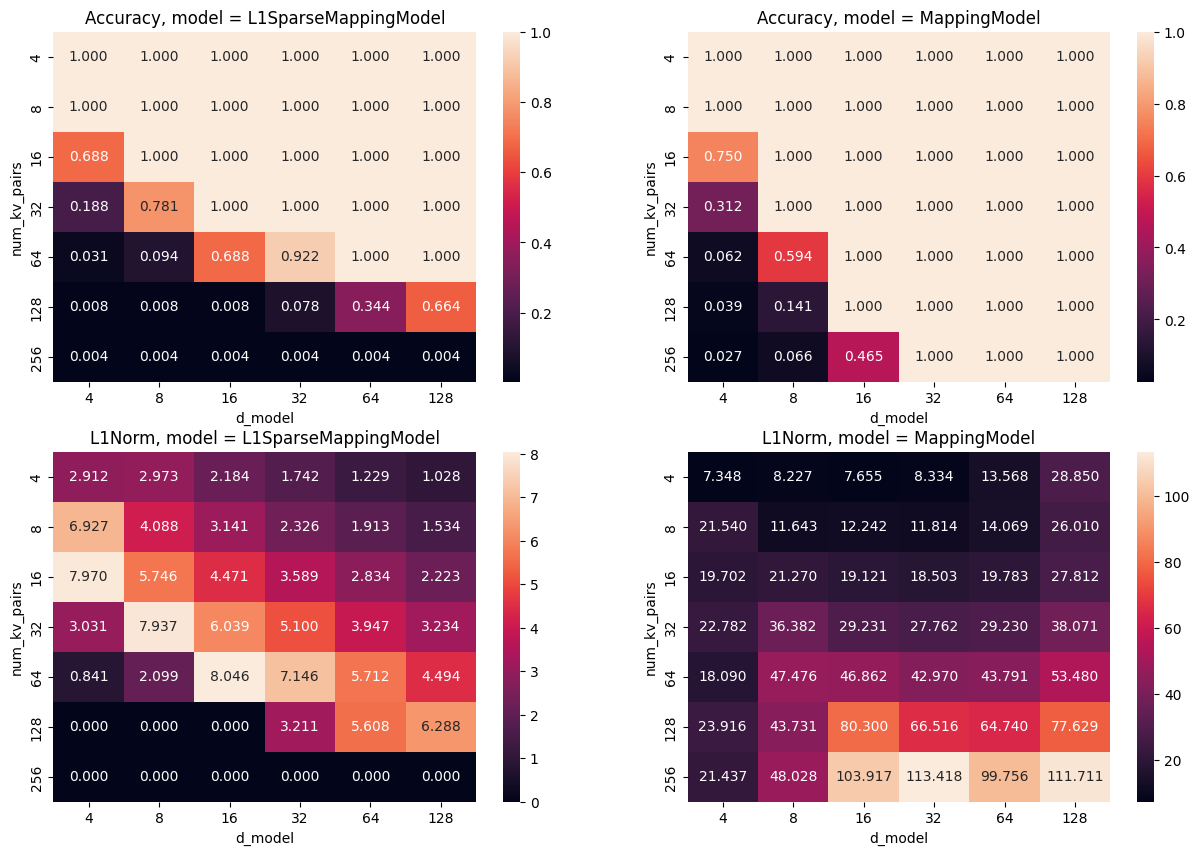

In [77]:
# Pivot the data
df = pd.DataFrame(results)
ig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust the size as needed

for i, model in enumerate(df["model"].unique()):  # Assuming you want to create heatmaps for both True and False
    pivot_df = df[df["model"] == model].pivot(index='num_kv_pairs', columns='d_model', values='accuracy')
    
    # Create the heatmap
    sns.heatmap(pivot_df, annot=True, fmt=".3f", ax=axs[0, i])
    axs[0, i].set_title(f'Accuracy, model = {model}')


for i, model in enumerate(df["model"].unique()):  # Assuming you want to create heatmaps for both True and False
    pivot_df = df[df["model"] == model].pivot(index='num_kv_pairs', columns='d_model', values='norm')
    
    # Create the heatmap
    sns.heatmap(pivot_df, annot=True, fmt=".3f", ax=axs[1, i])
    axs[1, i].set_title(f'L1Norm, model = {model}')

In [86]:
results = []
for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
    for num_kv_pairs in tqdm([4, 8, 16, 32, 64, 128, 256]):
        for d_model in [4, 8, 16, 32, 64, 128]:
            metrics, _, meta, _, _ = fit_model(
                num_kv_pairs=num_kv_pairs, 
                d_model=d_model, 
                model_cls=L1SparseMappingModel,
                num_epochs=800,
                device="cuda",
                alpha=alpha
            )
            results.append(
                {
                    'model': f"{L1SparseMappingModel.__name__}({alpha})",
                    'num_kv_pairs': num_kv_pairs,
                    'd_model': d_model,
                    "norm": torch.norm(meta["x1"]).item(),
                    **metrics
                }
            )
df = pd.DataFrame(results)


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


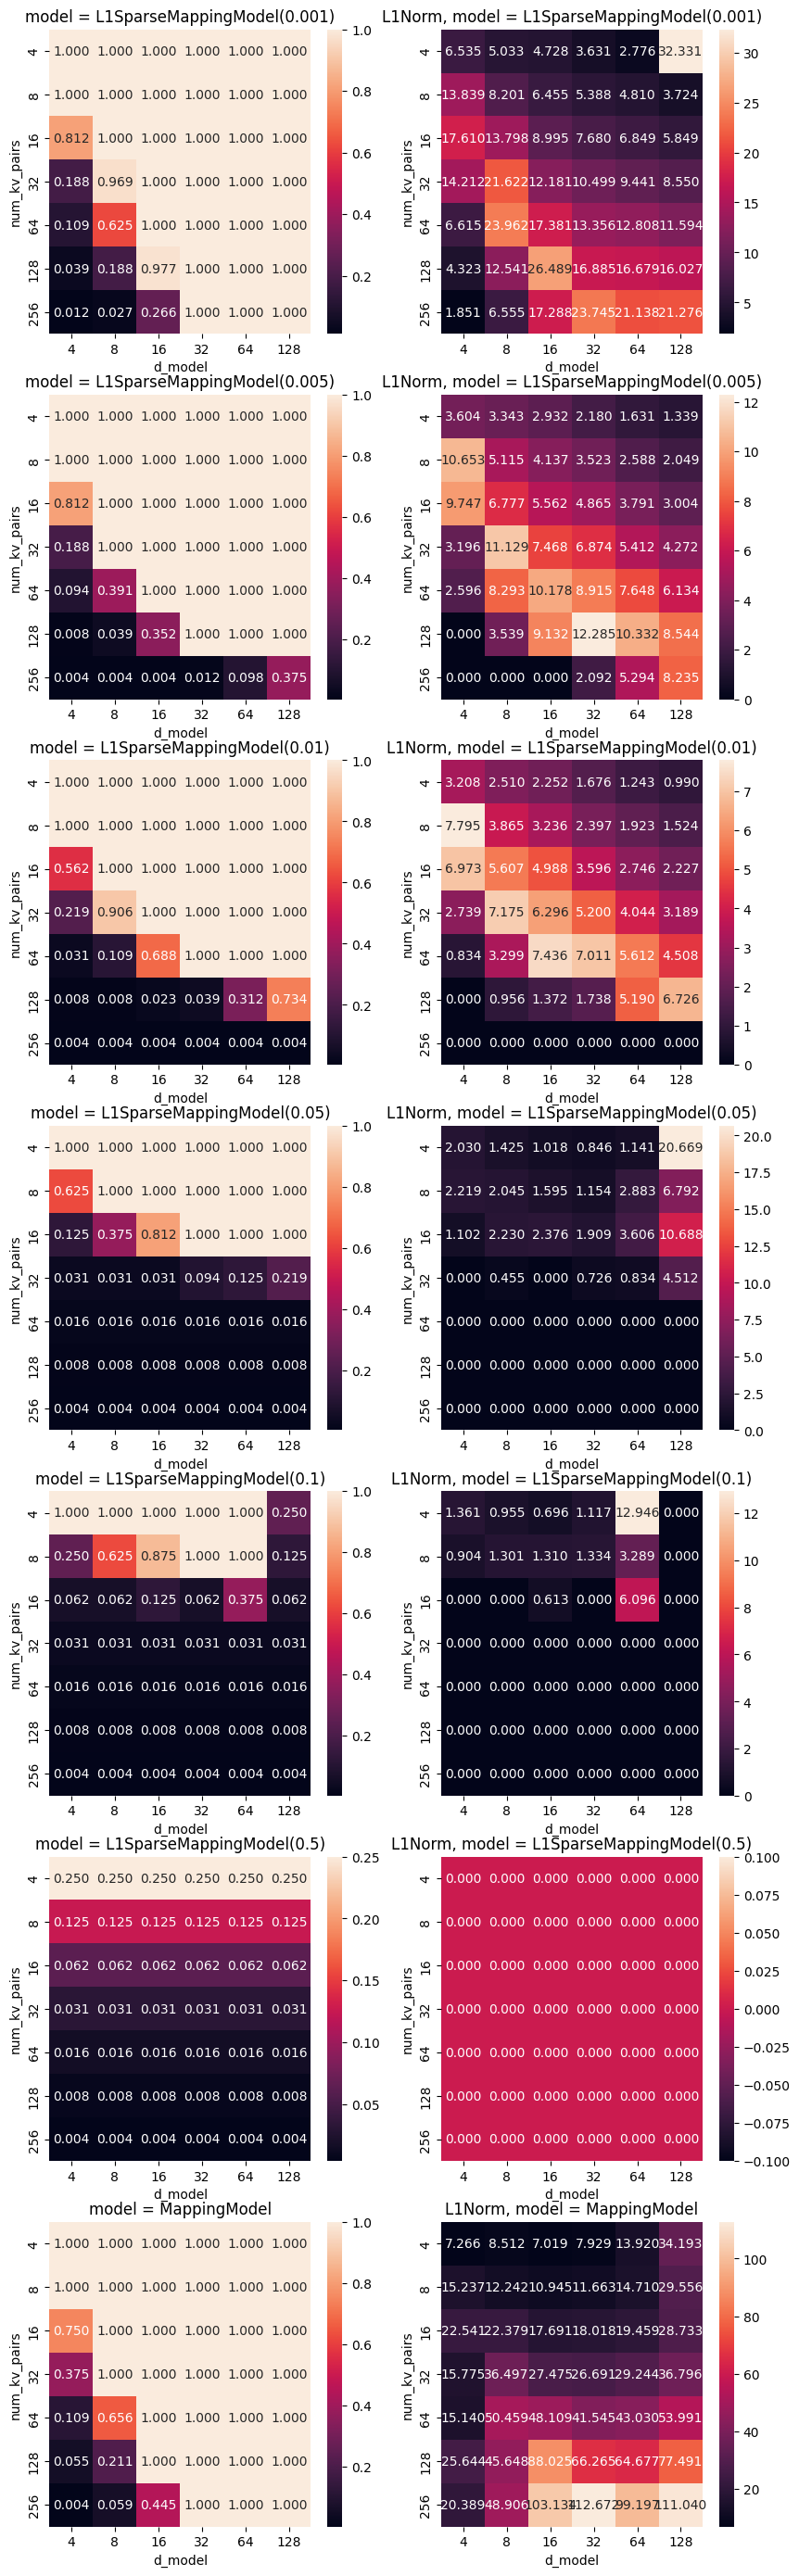

In [89]:
# Pivot the data
df = pd.DataFrame(results)
models = df["model"].unique()
fig, axs = plt.subplots(len(models), 2, figsize=(10, 5 * len(models)))  # Adjust the size as needed

for i, model in enumerate(models):  # Assuming you want to create heatmaps for both True and False
    pivot_df = df[df["model"] == model].pivot(index='num_kv_pairs', columns='d_model', values='accuracy')
    # Create the heatmap
    sns.heatmap(pivot_df, annot=True, fmt=".3f", ax=axs[i, 0])
    axs[i, 0].set_title(f'model = {model}')

    
    pivot_df = df[df["model"] == model].pivot(index='num_kv_pairs', columns='d_model', values='norm')
    # Create the heatmap
    sns.heatmap(pivot_df, annot=True, fmt=".3f", ax=axs[i, 1])
    axs[i, 1].set_title(f'L1Norm, model = {model}')